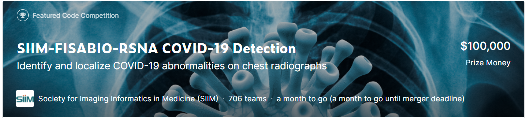

thanks https://www.kaggle.com/ayuraj/submission-covid19 I upvoked.
　　　　https://www.kaggle.com/ayuraj/train-covid-19-detection-using-yolov5 also,upvoked.

このコードを改良していくことにしました。yolo5をつかっているし、学習から推測まできれいにやってくれている<br>
学習フェーズは違いnotebookになっています。<br>
yolo5を知らない私にとっては、とてもいいかとおもってます。<br>
本で勉強したSSDはもう古いってことですかね。勉強したばっかりなんですけど。最新技術は本に載ってない。。。。

これをどう改善したらいいんだろう。やっぱり学習モデルからかなあ。とりあえず初回は、0.244でした。<br>
学習モデルを改善したら0.316になりました。先は遠い今現在トップの人は0.651なんですね。<br>
yolo勉強してます。実装方法はわかりましたが、仕組みがわからないです。<br>
ようやくオリジナルのスコアを超えました。しかし、ここからどうやってスコアをあげていけばいいのか。

> 　v5はUltralytics LLC　スペインの企業が発表したものですが、論文や詳細情報がなく、Redmon氏とのかかわりも不透明でその正当性に関して問題視する意見がウェブ上で存在しています。また性能に関してもv4の方がよいという比較結果を載せているウェブサイトもみられ、v5はその立ち位置などを含め取扱い方が難しいといえます。モデルはウェブ上にオープンにされているので、実際に自身でご利用して判断されるのが一番かとおもいます。うーん。<br>
> yolov4の論文はこれです<br>

> https://arxiv.org/pdf/2004.10934.pdf

このモデルはEfficentNetとYoloV5を組み合わせています。仕組みは理解できていません。<br>
https://towardsdatascience.com/fusing-efficientnet-yolov5-advanced-object-detection-2-stage-pipeline-tutorial-da3a77b118d1

# August 9, 2021 - Final Submission Deadline.

### Install 

In [ ]:

!conda install '/kaggle/input/pydicom-conda-helper/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y


### Imports

In [ ]:
import tensorflow as tf
print(tf.__version__)
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

import os
import gc
import cv2
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

### Load Submission 

In [ ]:
# Read the submisison file
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')
print(len(sub_df))
sub_df.head()

studyとimageを出力しないといけない。studyはnegativeが多いですね。

In [ ]:
study_df = sub_df.loc[sub_df.id.str.contains('_study')]
len(study_df)

In [ ]:
study_df

こちらはイメージファイルなのでわかりやすい。こちらは、noneになっている。どういう意味？

In [ ]:
image_df = sub_df.loc[sub_df.id.str.contains('_image')]
len(image_df)

In [ ]:
image_df

### 画像を抽出してサイズを変更するためのユーティリティ

read_xrayはちゃんと入力ファイルからdicomファイルを読んでいる。

In [ ]:

def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


### 512*512バイトにリサイズしている。

In [ ]:

def resize_xray(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im


In [ ]:

TEST_PATH = f'/kaggle/tmp/test/'
IMG_SIZE = 512

def prepare_test_images():
    image_id = []
    dim0 = []
    dim1 = []

    os.makedirs(TEST_PATH, exist_ok=True)

    for dirname, _, filenames in tqdm(os.walk(f'../input/siim-covid19-detection/test')):
        for file in filenames:
            # set keep_ratio=True to have original aspect ratio
            xray = read_xray(os.path.join(dirname, file))
            im = resize_xray(xray, size=IMG_SIZE)  
            im.save(os.path.join(TEST_PATH, file.replace('dcm', 'png')))

            image_id.append(file.replace('.dcm', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])
            
    return image_id, dim0, dim1


### テスト画像を準備する（データセット化する）→失敗しました。データセット化すると解決できないエラーが発生します。

In [ ]:

image_ids, dim0, dim1 = prepare_test_images()
print(f'Number of test images: {len(os.listdir(TEST_PATH))}')


In [ ]:
'''
import tarfile
with tarfile.open('SIIM-test-size512.tar.gz', 'w:gz') as t:
     for i in list:
        t.add(i)
'''

In [ ]:
'''
!cp SIIM-test-size512.tar.gz /kaggle/working
'''

In [ ]:
'''
test_list = pd.DataFrame(index=range(len(list)), data={"image_id":image_ids})
test_list['dim0'] = dim0
test_list['dim1'] = dim1
test_list.to_csv('/kaggle/working/test_list.csv')
'''

In [ ]:
'''
meta_df = pd.read_csv('../input/siimresize512/test_list .csv')
meta_df = meta_df.rename(columns={'id':'image_id'})
meta_df
'''

In [ ]:
!ls ../input/siimresize512/

ここで、studyとimageを統合していますね。

In [ ]:
meta_df = pd.DataFrame.from_dict({'image_id': image_ids, 'dim0': dim0, 'dim1': dim1})

# Associate image-level id with study-level ids.
# Note that a study-level might have more than one image-level ids.
for study_dir in os.listdir('../input/siim-covid19-detection/test'):
    for series in os.listdir(f'../input/siim-covid19-detection/test/{study_dir}'):
        for image in os.listdir(f'../input/siim-covid19-detection/test/{study_dir}/{series}/'):
            image_id = image[:-4]
            meta_df.loc[meta_df['image_id'] == image_id, 'study_id'] = study_dir
        
meta_df.head()

# YOLOv5推論

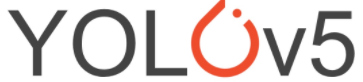

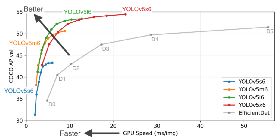

### 学習済モデルを作ってdatasetsにしておく。わかりやすいので、みんなできると思う。google driveで8時間かけて学習させました。<br>
### あと、YOLOv5xにして、sizeを512に変えています。5xの方がスコアが高いけど時間はすごくかかります。

## ものスゴーく時間かけてやった割りには、スコアが上がらず、心が折れました。
https://www.kaggle.com/ayuraj/train-covid-19-detection-using-yolov5

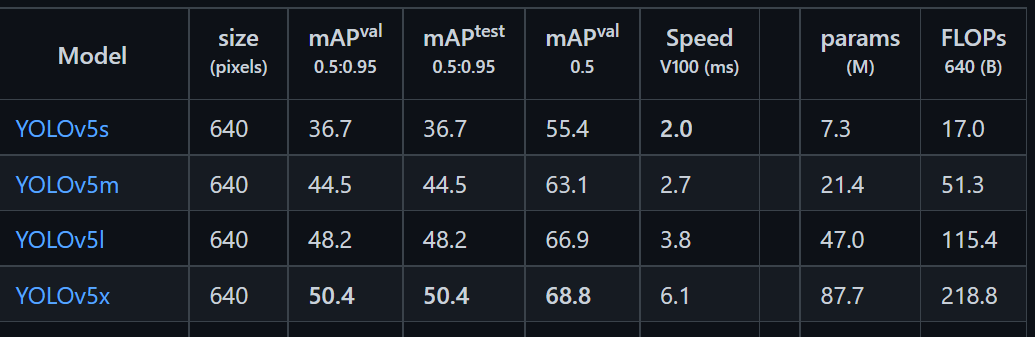

In [ ]:
!cp ../input/siimresize512/yolov5x.pt /kaggle/working
!cp ../input/siimresize512/requirements.txt /kaggle/working

In [ ]:
#TEST_PATH = f'../input/siimresize512/SIIM-test-size512/kaggle/tmp/test/'
IMG_SIZE = 512

# ここでyolov5登場

In [ ]:
YOLO_MODEL_PATH = '../input/siimyolo5/best.pt'

!python ../input/kaggle-yolov5/detect.py --weights {YOLO_MODEL_PATH} \
                                      --source {TEST_PATH} \
                                      --img {IMG_SIZE} \
                                      --conf 0.22 \
                                      --iou-thres 0.5 \
                                      --max-det 10 \
                                      --save-txt \
                                      --save-conf

In [ ]:
PRED_PATH = 'runs/detect/exp/labels'
prediction_files = os.listdir(PRED_PATH)
print(f'Number of opacity predicted by YOLOv5: {len(prediction_files)}')

## Hyperparameters

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

CONFIG = dict (
    seed = 42,
    num_labels = 4,
    num_folds = 5,
    img_width = 512,
    img_height = 512,
    batch_size = 32,
    _wandb_kernel = 'ayut',
    architecture = "CNN",
    infra = "GCP",
)

## testloader用意

In [ ]:
image_df['path'] = image_df.apply(lambda row: TEST_PATH+row.id.split('_')[0]+'.png', axis=1)
image_df = image_df.reset_index(drop=True)
image_df['path'][0] 

In [ ]:
@tf.function
def decode_image(image):
    # convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_png(image, channels=3)
    # Normalize image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

@tf.function
def load_image(df_dict):
    # Load image
    image = tf.io.read_file(df_dict['path'])
    image = decode_image(image)
    
    # ここで512にリサイズしているということは、入力ファイルはリサイズ済みのものではない方がいいのかな。yoloはリサイズ済のものを想定している。
    image = tf.image.resize(image, (CONFIG['img_height'], CONFIG['img_width']))
    
    return image

testloader = tf.data.Dataset.from_tensor_slices(dict(image_df))

testloader = (
    testloader
    .shuffle(1024)
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(CONFIG['batch_size'])
    .prefetch(AUTOTUNE)
)

### 学習済のEfficientNETを利用。512*512ベース。このファイルの作り方はわからなかった。

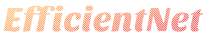

### GPU時間が足らないため、これ以降の調査は来週。。。

In [ ]:
# Load Model
STUDY_MODEL_PATHS = '../input/siim-study-level-models/effnet-mixup/effnetb0_mixup/'
study_models = os.listdir(STUDY_MODEL_PATHS)
study_models

## 推測

In [ ]:
predictions = []
for model in study_models:
    # Load model
    tf.keras.backend.clear_session()
    model = tf.keras.models.load_model(STUDY_MODEL_PATHS+model)
    # Prediction
    tmp = []
    for img_batch in tqdm(testloader):
        preds = model.predict(img_batch)
        tmp.extend(preds)
        
    predictions.append(tmp)
    
    del model
    _ = gc.collect()
    
predictions = np.mean(predictions, axis=0)

・append()メソッドとは,引数に渡された値をリストの末尾に渡します。<br>
・extend()メソッドとは,引数に渡された別のリストを追加してリストを拡張します。<br>

文字列の場合、appendで追加するが、extendだと一文字ずつ追加される。<br>
　　 my_list2 = ['dog', 'cat']<br>
　　 my_list2.extend('bat')<br>
　　 my_list2<br>
　　['dog', 'cat', 'b', 'a', 't']<br>
extendで要素を渡して、エラーを起こす。

In [ ]:
class_labels = ['0', '1', '2', '3']
image_df.loc[:, class_labels] = predictions
image_df.head()

In [ ]:
class_to_id = { 
    'negative': 0,
    'typical': 1,
    'indeterminate': 2,
    'atypical': 3}
id_to_class  = {v:k for k, v in class_to_id.items()}

def get_study_prediction_string(preds, threshold=0):
    string = ''
    for idx in range(4):
        conf =  preds[idx]
        if conf>threshold:
            string+=f'{id_to_class[idx]} {conf:0.2f} 0 0 1 1 '
    string = string.strip()
    return string

In [ ]:
study_ids = []
pred_strings = []

for study_id, df in meta_df.groupby('study_id'):
    # accumulate preds for diff images belonging to same study_id
    tmp_pred = []
    
    df = df.reset_index(drop=True)
    for image_id in df.image_id.values:
        preds = image_df.loc[image_df.id == image_id+'_image'].values[0]
        tmp_pred.append(preds[3:])
    
    preds = np.mean(tmp_pred, axis=0)
    pred_string = get_study_prediction_string(preds)
    pred_strings.append(pred_string)
    
    study_ids.append(f'{study_id}_study')
    
study_df = pd.DataFrame.from_dict({'id': study_ids, 'PredictionString': pred_strings})
study_df.head()

# Merge Results

In [ ]:
# The submisison requires xmin, ymin, xmax, ymax format. 
# YOLOv5 returns x_center, y_center, width, height
def correct_bbox_format(bboxes):
    correct_bboxes = []
    for b in bboxes:
        xc, yc = int(np.round(b[0]*IMG_SIZE)), int(np.round(b[1]*IMG_SIZE))
        w, h = int(np.round(b[2]*IMG_SIZE)), int(np.round(b[3]*IMG_SIZE))

        xmin = xc - int(np.round(w/2))
        ymin = yc - int(np.round(h/2))
        xmax = xc + int(np.round(w/2))
        ymax = yc + int(np.round(h/2))
        
        correct_bboxes.append([xmin, ymin, xmax, ymax])
        
    return correct_bboxes

def scale_bboxes_to_original(row, bboxes):
    # Get scaling factor
    scale_x = IMG_SIZE/row.dim1
    scale_y = IMG_SIZE/row.dim0
    
    scaled_bboxes = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        
        xmin = int(np.round(xmin/scale_x))
        ymin = int(np.round(ymin/scale_y))
        xmax = int(np.round(xmax/scale_x))
        ymax = int(np.round(ymax/scale_y))
        
        scaled_bboxes.append([xmin, ymin, xmax, ymax])
        
    return scaled_bboxes

# Read the txt file generated by YOLOv5 during inference and extract 
# confidence and bounding box coordinates.
def get_conf_bboxes(file_path):
    confidence = []
    bboxes = []
    with open(file_path, 'r') as file:
        for line in file:
            preds = line.strip('\n').split(' ')
            preds = list(map(float, preds))
            confidence.append(preds[-1])
            bboxes.append(preds[1:-1])
    return confidence, bboxes

In [ ]:
image_pred_strings = []
for i in tqdm(range(len(image_df))):
    row = meta_df.loc[i]
    id_name = row.image_id
    
    if f'{id_name}.txt' in prediction_files:
        # opacity label
        confidence, bboxes = get_conf_bboxes(f'{PRED_PATH}/{id_name}.txt')
        bboxes = correct_bbox_format(bboxes)
        ori_bboxes = scale_bboxes_to_original(row, bboxes)
        
        pred_string = ''
        for j, conf in enumerate(confidence):
            pred_string += f'opacity {conf} ' + ' '.join(map(str, ori_bboxes[j])) + ' '
        image_pred_strings.append(pred_string[:-1]) 
    else:
        image_pred_strings.append("none 1 0 0 1 1")

In [ ]:
meta_df['PredictionString'] = image_pred_strings
image_df = meta_df[['image_id', 'PredictionString']]
image_df.insert(0, 'id', image_df.apply(lambda row: row.image_id+'_image', axis=1))
image_df = image_df.drop('image_id', axis=1)
image_df.head()

In [ ]:
sub_df

### imageの順番がsampleと異なるとエラーになるため補正する。→気のせいだった。なんだろうか。

In [ ]:
'''
image = sub_df.copy()
image =image.drop(image.index[:1214])
image =image.reset_index()
image = image.drop(['index'],axis=1)
image
'''

In [ ]:
'''
for r in tqdm(range(len(image))):
   for i in range(len(image)):
       if image.iloc[r].id == image_df.iloc[i].id:
         image.iloc[r].PredictionString = image_df.iloc[i].PredictionString
         break
'''        

In [ ]:
!rm -rf runs

In [ ]:
sub_df = pd.concat([study_df, image_df])
sub_df.to_csv('submission.csv', index=False)
sub_df

In [ ]:
image